In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


In [20]:
# Define paths
dataset_path = '/kaggle/input/grape-disease-dataset-original'
train_path = os.path.join(dataset_path, 'Original Data', 'train')
test_path = os.path.join(dataset_path, 'Original Data', 'test')

# List classes
classes = os.listdir(train_path)
print(f"Classes: {classes}")

# Count images in each class (train)
for cls in classes:
    print(f"Train {cls}: {len(os.listdir(os.path.join(train_path, cls)))} images")

# Count images in each class (test)
for cls in classes:
    print(f"Test {cls}: {len(os.listdir(os.path.join(test_path, cls)))} images")

Classes: ['ESCA', 'Healthy', 'Leaf Blight', 'Black Rot']
Train ESCA: 1920 images
Train Healthy: 1692 images
Train Leaf Blight: 1722 images
Train Black Rot: 1888 images
Test ESCA: 480 images
Test Healthy: 423 images
Test Leaf Blight: 430 images
Test Black Rot: 472 images


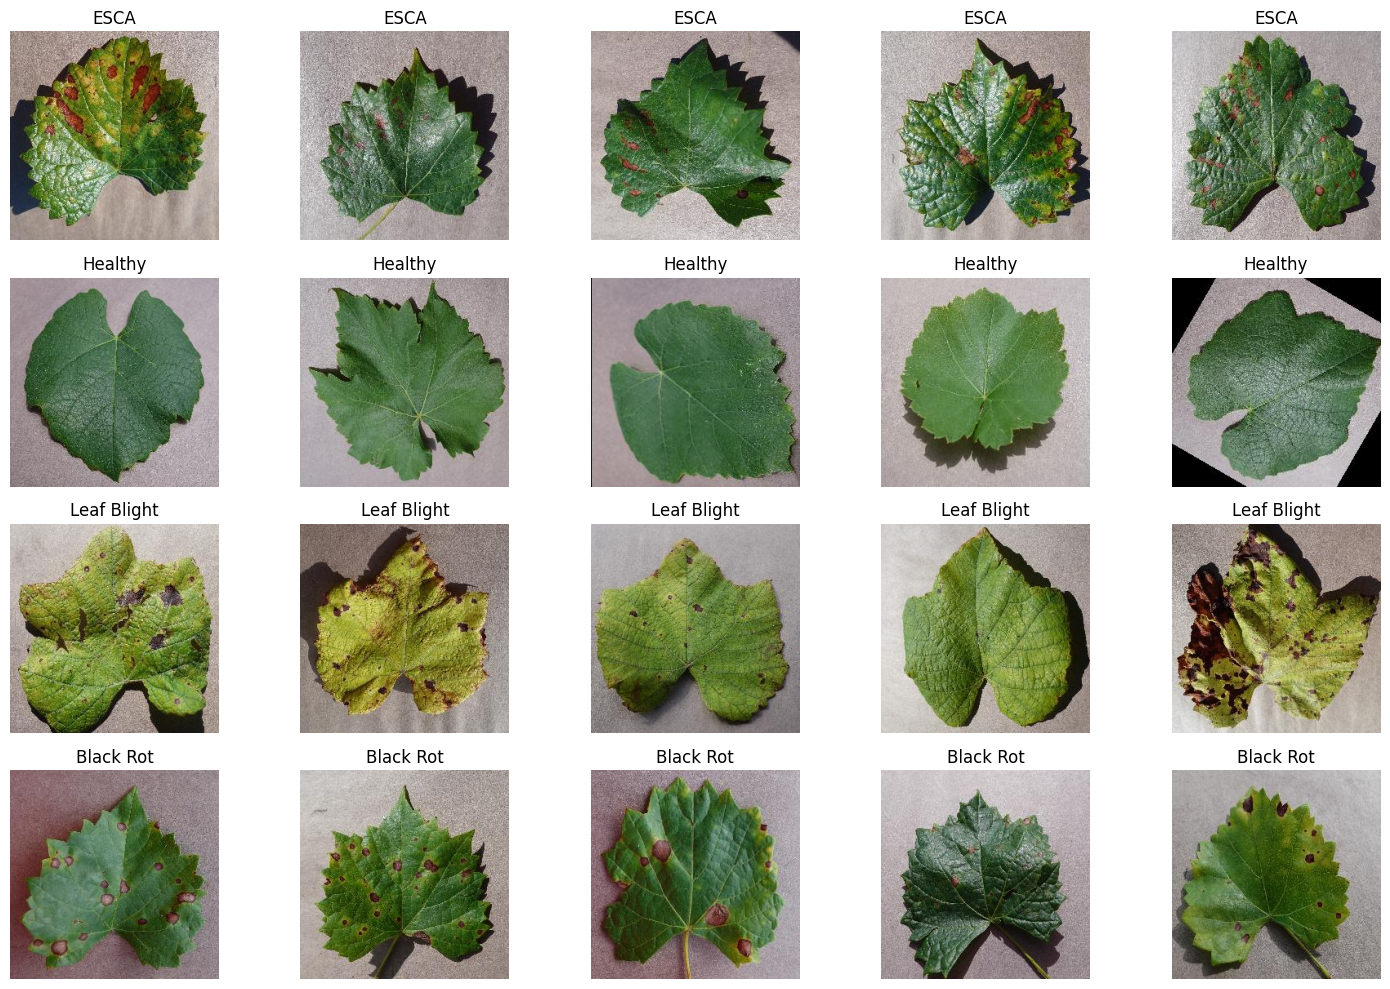

In [3]:
# Function to show sample images
def show_samples(path, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)[:num_samples]
        
        for j, img_name in enumerate(images):
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show train samples
show_samples(train_path)

Image dimensions summary:
       width  height
count   40.0    40.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


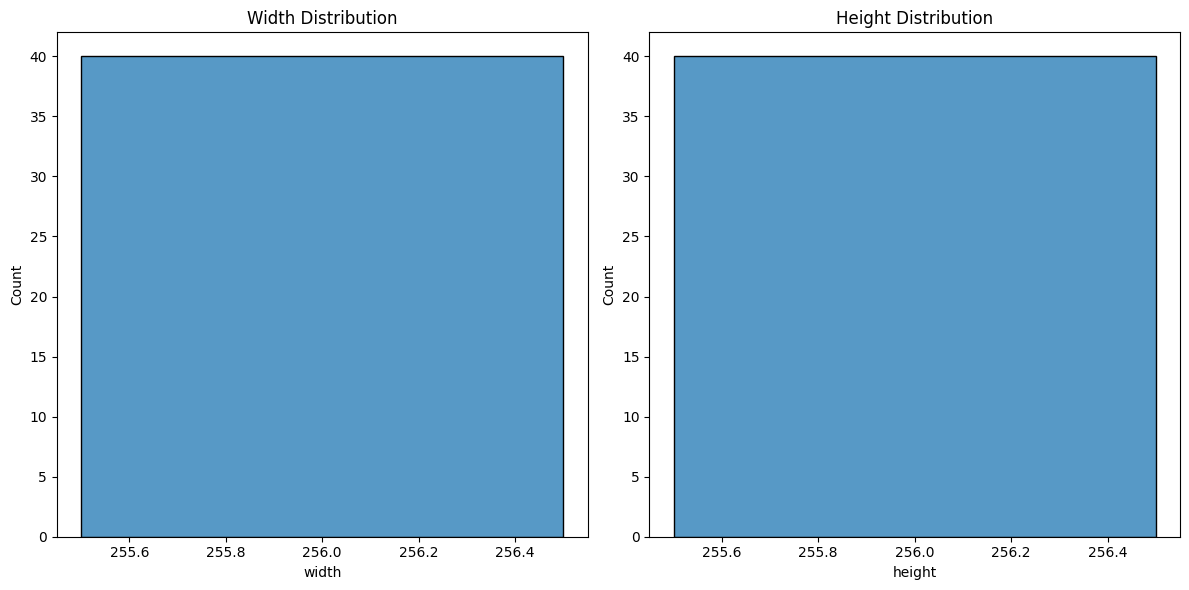

In [4]:
# Check image dimensions
def check_dimensions(path):
    dimensions = []
    for cls in classes:
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path)[:10]:  # Check first 10 images
            img = Image.open(os.path.join(class_path, img_name))
            dimensions.append(img.size)
    
    return pd.DataFrame(dimensions, columns=['width', 'height'])

dim_df = check_dimensions(train_path)
print("Image dimensions summary:")
print(dim_df.describe())

# Plot dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dim_df['width'])
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dim_df['height'])
plt.title('Height Distribution')
plt.tight_layout()
plt.show()

In [21]:

# Set image size dynamically (EfficientNetB0 typically uses 224x224)
IMG_SIZE = (224, 224)

# Data augmentation for training and rescaling for both training and testing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    validation_split=0.2      # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Apply EfficientNet preprocessing

# Function to create the data generator
def create_generator(directory, datagen, subset=None):
    return datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        subset=subset  # Only used for training and validation sets
    )

# Create training generator
train_generator = create_generator(train_path, train_datagen, subset='training')

# Create validation generator from the same data (using validation_split)
validation_generator = create_generator(train_path, train_datagen, subset='validation')

# Create test generator without augmentation (but with preprocessing)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)


Found 5779 images belonging to 4 classes.
Found 1443 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.


# **Custom cnn model**

In [22]:

def plot_training_history(history, model_name='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the CNN model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Convolutional Block 4 (Added)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Global Pooling and Dense Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Optimizer with gradient clipping
opt = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 145s 696ms/step - accuracy: 0.7353 - loss: 5.2459 - val_accuracy: 0.6334 - val_loss: 4.8143 - learning_rate: 1.0000e-04
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 529ms/step - accuracy: 0.9076 - loss: 4.0016 - val_accuracy: 0.8434 - val_loss: 3.5798 - learning_rate: 1.0000e-04
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 523ms/step - accuracy: 0.9361 - loss: 3.2451 - val_accuracy: 0.9203 - val_loss: 2.8454 - learning_rate: 1.0000e-04
Epoch 4/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 530ms/step - accuracy: 0.9545 - loss: 2.6518 - val_accuracy: 0.9598 - val_loss: 2.2863 - learning_rate: 1.0000e-04
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 524ms/step - accuracy: 0.9685 - loss: 2.1876 - val_accuracy: 0.9328 - val_loss: 1.9829 - learning_rate: 1.0000e-04
Epoch 6/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 525ms/step - accuracy: 0.9775 - loss: 1.8082 - val_accuracy: 0.9141 - val_loss: 1.7234 - learning_rate: 1.0000e-04
Epoch 7/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 526ms/step -

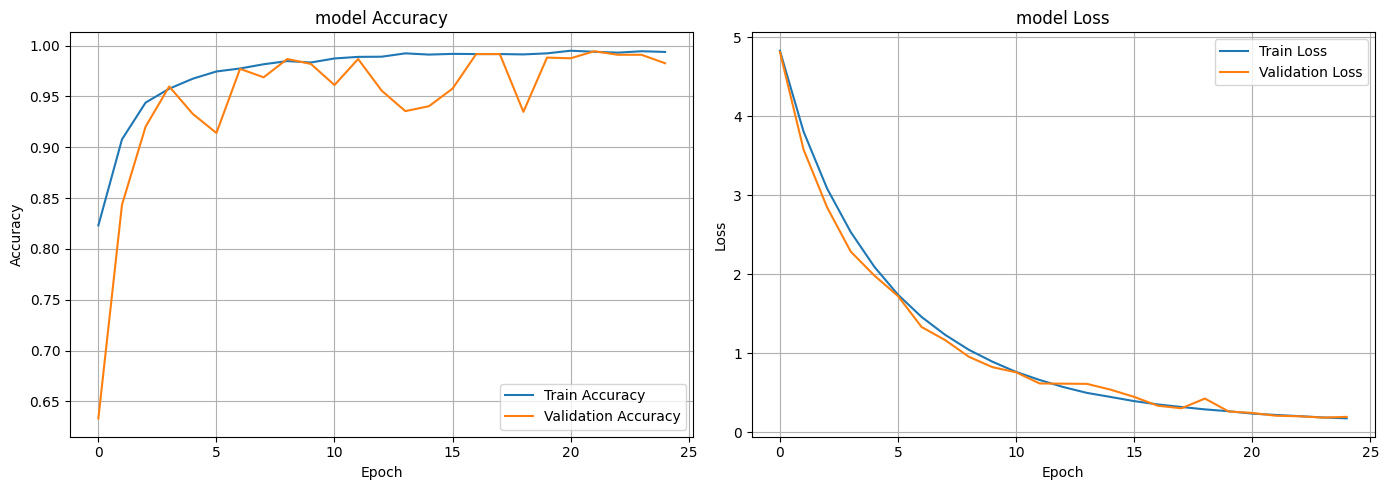

In [9]:
# Call the function
plot_training_history(history, model_name='model')

In [10]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
# Improved model 2
model_2 = Sequential()

# Convolutional Block 1
model_2.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model_2.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model_2.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D((2, 2)))

# Global Average Pooling instead of Flatten
model_2.add(GlobalAveragePooling2D())

# Fully Connected Layers
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(train_generator.num_classes, activation='softmax'))

# Optimizer with better LR
opt = Adam(learning_rate=0.00025, decay=1e-6)

# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping & LR reduction
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model with early stopping and learning rate reduction
history2 = model_2.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 114s 527ms/step - accuracy: 0.7145 - loss: 0.9822 - val_accuracy: 0.5655 - val_loss: 1.7258 - learning_rate: 2.5000e-04
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 458ms/step - accuracy: 0.8727 - loss: 0.5757 - val_accuracy: 0.9155 - val_loss: 0.4795 - learning_rate: 2.5000e-04
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 458ms/step - accuracy: 0.9006 - loss: 0.4914 - val_accuracy: 0.8877 - val_loss: 0.4891 - learning_rate: 2.5000e-04
Epoch 4/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9218 - loss: 0.4053
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 462ms/step - accuracy: 0.9218 - loss: 0.4053 - val_accuracy: 0.8046 - val_loss: 0.6923 - learning_rate: 2.5000e-04
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 463ms/step - accuracy: 0.9433 - loss: 0.3573 - val_accuracy: 0.8954 - val_loss: 0.4399 - learning_rate: 1.2500e-04
Epoch 6/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 462ms/s

In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8886 - loss: 0.4777
Test Accuracy: 0.8936


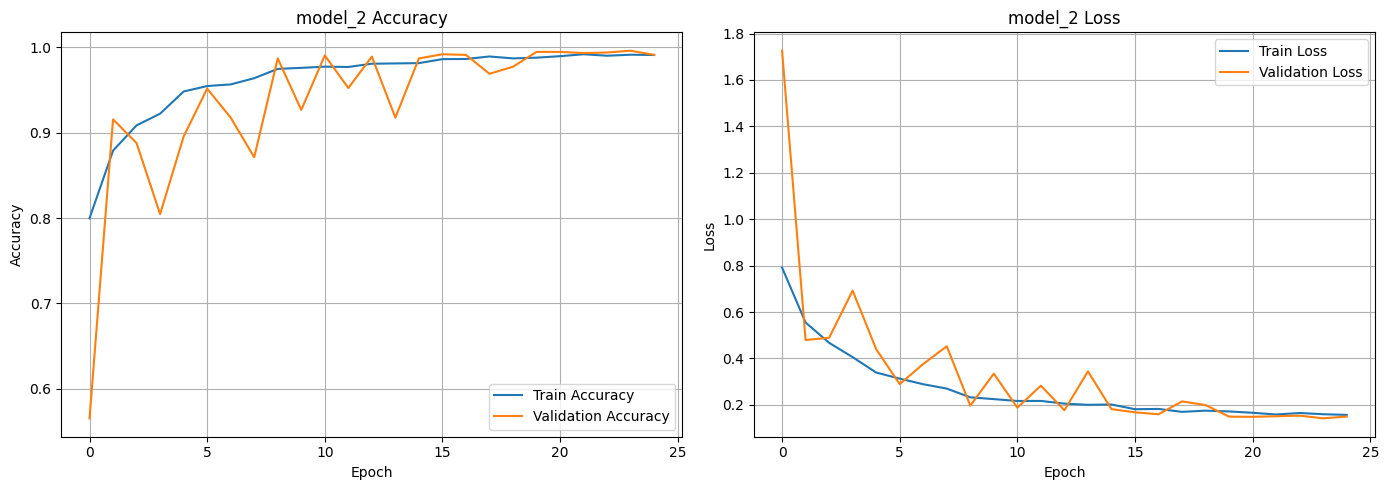

In [12]:
# Call the function
plot_training_history(history2, model_name='model_2')

# **EfficientNet**

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained EfficientNetB0 model with 224x224 input shape
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model layers
for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Increased regularization and dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)  # Increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)  # Increased dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Lower initial learning rate
opt = Adam(learning_rate=0.0001, decay=1e-6)
efficientnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Improved callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
historyeff = efficientnet_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 140s 609ms/step - accuracy: 0.6841 - loss: 2.0245 - val_accuracy: 0.9757 - val_loss: 1.2267 - learning_rate: 1.0000e-04
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.9513 - loss: 1.2689 - val_accuracy: 0.9875 - val_loss: 1.0920 - learning_rate: 1.0000e-04
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 454ms/step - accuracy: 0.9745 - loss: 1.1220 - val_accuracy: 0.9931 - val_loss: 0.9859 - learning_rate: 1.0000e-04
Epoch 4/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 462ms/step - accuracy: 0.9767 - loss: 1.0094 - val_accuracy: 0.9889 - val_loss: 0.8978 - learning_rate: 1.0000e-04
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 473ms/step - accuracy: 0.9886 - loss: 0.8947 - val_accuracy: 0.9972 - val_loss: 0.7946 - learning_rate: 1.0000e-04
Epoch 6/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.9886 - loss: 0.8010 - val_accuracy: 0.9938 - val_loss: 0.7164 - learning_rate: 1.000

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.9984 - loss: 0.0713
Test Accuracy: 0.9972


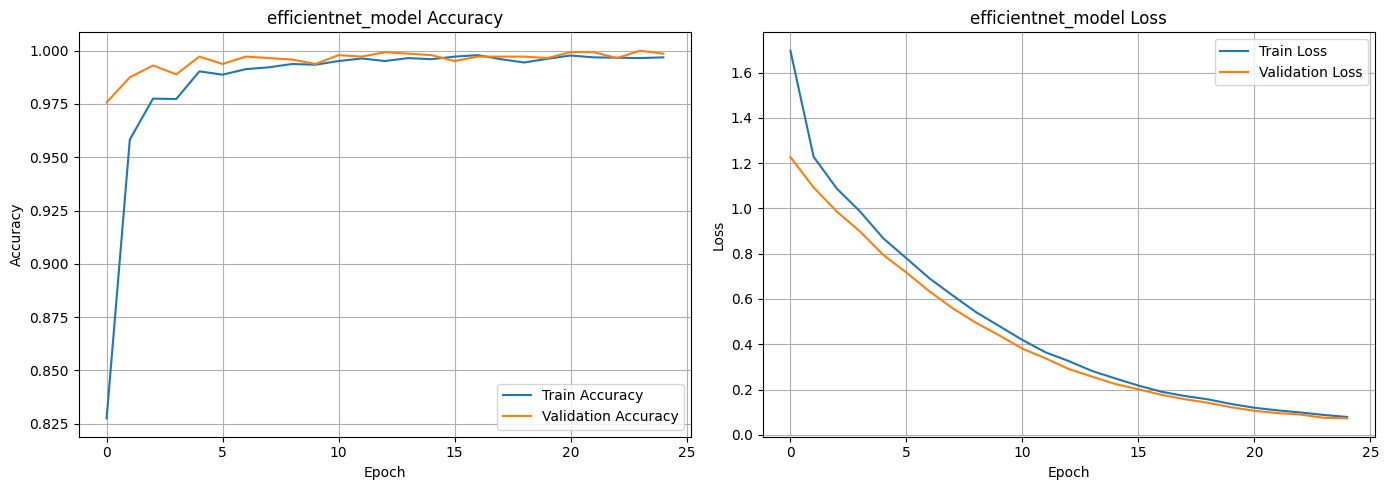

In [15]:
# Call the function
plot_training_history(historyeff, model_name='efficientnet_model')

# **Mobilenetv2**

In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained MobileNetV2 model with 224x224 input shape
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model layers
for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
mobilenet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
historymob = mobilenet_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 91s 442ms/step - accuracy: 0.5896 - loss: 2.1610 - val_accuracy: 0.4061 - val_loss: 2.8688 - learning_rate: 1.0000e-04
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 75s 401ms/step - accuracy: 0.8465 - loss: 1.5499 - val_accuracy: 0.5551 - val_loss: 2.3886 - learning_rate: 1.0000e-04
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 75s 402ms/step - accuracy: 0.9082 - loss: 1.3595 - val_accuracy: 0.4872 - val_loss: 4.3124 - learning_rate: 1.0000e-04
Epoch 4/25
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9096 - loss: 1.3071
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
181/181 ━━━━━━━━━━━━━━━━━━━━ 76s 405ms/step - accuracy: 0.9096 - loss: 1.3066 - val_accuracy: 0.3832 - val_loss: 5.5327 - learning_rate: 1.0000e-04
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 76s 405ms/step - accuracy: 0.9238 - loss: 1.2054 - val_accuracy: 0.5787 - val_loss: 2.9691 - learning_rate: 5.0000e-05
Epoch 6/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 76s 405ms/st

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9112 - loss: 1.0129
Test Accuracy: 0.9152


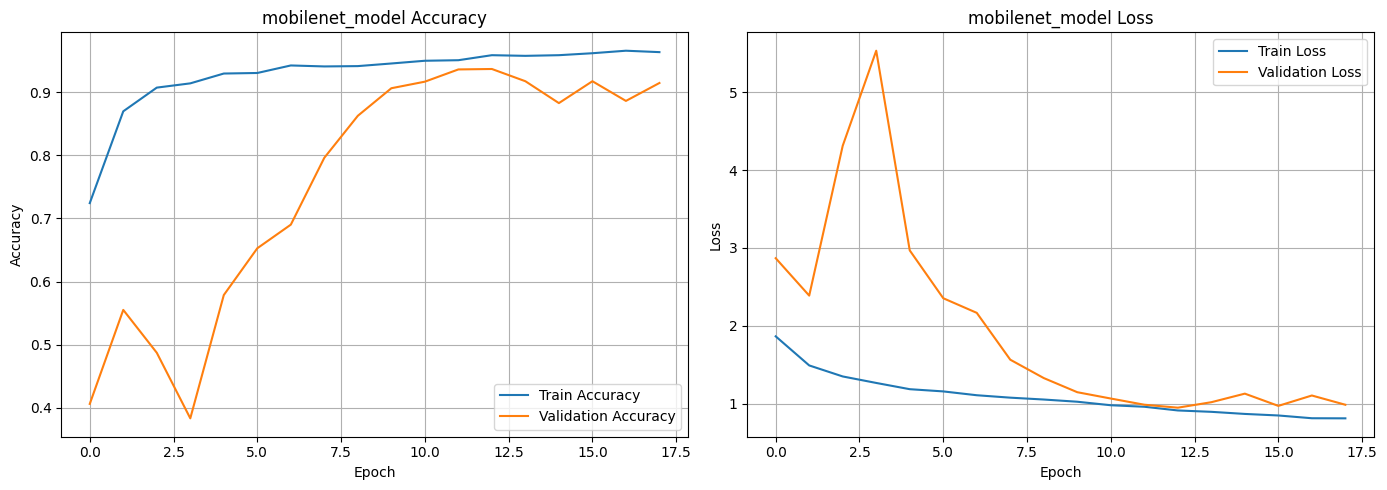

In [25]:
# Call the function
plot_training_history(historymob, model_name='mobilenet_model')